### importing the data

To load the dataset we import it in different smaller chunks, otherwise, due to its size, it wouldn't be possible load it.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To use the import in chunks we first need to set the pandas version to 1.0.5

In [2]:
!pip install pandas==1.0.5

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Start looking at smaller chunks to prepare a data cleaning pipeline

In [4]:
# Here we load into memory just the first chunk to take a look at the data and use it to prepare a cleaning pipeline that will
# be used for our entire final dataset
df_reader = pd.read_json('/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=1000000)
for chunk in df_reader:
   chunk_test = chunk
   break

In [5]:
chunk_test.columns

Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')

In [6]:
chunk_test.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E


we can already see that for our analysis we will need just six columns, so we will import just them in future to lower the computational cost of the import and facilitate it.

In [7]:
chunk_test = chunk_test.drop(['date', 'urls', 'phase'], axis = 1)

#### Now we import the speakers' attributes to be able to select those who we are interested in

In [8]:
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/Project datasets/speaker_attributes.parquet')

In [9]:
speaker_attributes.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


We can already dro some columns that we will not use for sure.

In [10]:
speaker_attributes.drop(['lastrevid', 'type', 'religion'], axis = 1, inplace = True)

In [11]:
speaker_attributes.columns

Index(['aliases', 'date_of_birth', 'nationality', 'gender', 'ethnic_group',
       'US_congress_bio_ID', 'occupation', 'party', 'academic_degree', 'id',
       'label', 'candidacy'],
      dtype='object')

as you can see all the information in the  `speaker_attributes ` dataframe are econded in terms of QIDs, so we want them in a human-readable fashion, so we import a dataset assigning to each QID a readable label.

In [12]:
readable = pd.read_csv('/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [13]:
readable.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


In [14]:
readable.loc['Q682443']['Label']

'Episcopal Church'

We want to first of all filter for politicians, so we select Hillary Clinton, for example, to assess which is the QIDs for politicians.

First we get her QID.

In [15]:
chunk_test.loc[chunk_test['speaker'] == 'Hillary Clinton'].qids.iloc[1]

['Q6294']

Then we used the obtained QID to see among her attributes the column `occupation`.

In [16]:
speaker_attributes.loc[speaker_attributes['id'] == 'Q6294'].occupation

1135081    [Q82955, Q40348, Q193391, Q36180, Q18814623, Q...
Name: occupation, dtype: object

We see that the first QID in the occupation corresponds to "politician" which is what we are interest into.

In [17]:
readable.loc['Q82955']['Label']

'politician'

Here we create a mask indicating the rows corresponding to politicians

In [18]:
# We create a mask dropping the rows with Nan in occupation, as we won't use
# them anyways as we want to keep just rows corresponding to politicians
mask_politicians = speaker_attributes.occupation.dropna().apply(lambda x: 'Q82955' in x)

Now we can get the QIDs corresponding to politicians

In [19]:
# We drop from the id column the rows containing nans in the occupation column, 
# so that we can apply the mask_ploiticians mask to the id column
qids_politicians = speaker_attributes['id'][~speaker_attributes['occupation'].isna()][mask_politicians]

In [20]:
qids_politicians

0                 Q23
3                Q207
5                Q368
11               Q815
15               Q946
              ...    
9055974    Q106406546
9055975    Q106406557
9055976    Q106406560
9055977    Q106406571
9055980    Q106406643
Name: id, Length: 657166, dtype: object

Furthermore, we want to focus on US politicias so in the same way as before we retrieve the QIDs associated to American nationality.

Again we need to find the QID corresponding to "American" and we use Hillary Clinton as an example.

In [21]:
speaker_attributes.loc[speaker_attributes['id'] == 'Q6294'].nationality

1135081    [Q30]
Name: nationality, dtype: object

In [22]:
readable.loc['Q30']['Label']

'United States of America'

In [23]:
mask_nationality = speaker_attributes.nationality.dropna().apply(lambda x: 'Q30' in x)
qids_americans = speaker_attributes['id'][~speaker_attributes['nationality'].isna()][mask_nationality]

Before removing the rows corresponding to non-American non-politicinas we noticies some oddities in the data: in particular we notice that some quotations have multiple QIDs in the `qids` column. For example it happens with Donald Trump.

In [24]:
chunk_test.loc[chunk_test['speaker'] == 'Donald Trump'].head()

,quoteID,quotation,speaker,qids,numOccurrences,probas
247,2020-02-19-010736,But I happen to like Prime Minister (Narendra)...,Donald Trump,"[Q22686, Q27947481]",8,"[[Donald Trump, 0.4138], [President Donald Tru..."
3172,2020-01-14-026600,"I didn't know that, no.. I hope she's okay,",Donald Trump,"[Q22686, Q27947481]",1,"[[Donald Trump, 0.5667], [None, 0.335], [Megha..."
6575,2020-02-13-078518,"So a leftist attacks 3 Trump supporters, inclu...",Donald Trump,"[Q22686, Q27947481]",3,"[[Donald Trump, 0.6995], [None, 0.2793], [Kimb..."
6740,2020-03-03-052722,The Democrat establishment is trying to take i...,Donald Trump,"[Q22686, Q27947481]",3,"[[Donald Trump, 0.5689], [President Trump, 0.3..."
8063,2020-01-08-021732,He killed thousands of US troops. He directed ...,Donald Trump,"[Q22686, Q27947481]",1,"[[Donald Trump, 0.9092], [None, 0.0908]]"


To find the cause of the issue we can look at `speaker_attributes` dataset:

In [25]:
speaker_attributes.loc[speaker_attributes['label'] == 'Donald Trump']

,aliases,date_of_birth,nationality,gender,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy
2267061,"[Donald John Trump, Donald J. Trump, Trump, Th...",[+1946-06-14T00:00:00Z],[Q30],[Q6581097],None,None,"[Q911554, Q557880, Q3427922, Q15980158, Q13152...","[Q29468, Q1897793, Q29552, Q29468, Q29468]",[Q787674],Q22686,Donald Trump,"[Q699872, Q22923830, Q38051523]"
8337605,"[Donald L. Trump, Donald Lynn Trump, Skip Trum...","[+1945-07-31T00:00:00Z, +1945-00-00T00:00:00Z]",[Q30],[Q6581097],None,None,"[Q39631, Q16062369]",None,[Q913404],Q27947481,Donald Trump,None


We can see that there is an issue in the way the `qids` column in the main dataset has been built, indeed to each quotation are assigned all the QIDs of the homonyms.
Since there is no way to fix this issue we decided to include in our filtered dataset only the quotations with a maximum of three assigned QIDs, provided that one of them corresponds to a politician. In this way we avoid to include many quotations from non politicians who just happen to be homonym of a politician but still without losing the quotations when the politician has just few homonyms.

We identify and remove the quotations with maximum three QIDs:

In [26]:
drop_quotes = chunk_test['qids'].apply(lambda x: len(x) < 4)

In [27]:
chunk_test_drop = chunk_test[drop_quotes]

We start by creating another mask, this time to be applied to the main dataframe (`chunk_test_drop`). This mask will consist of a combination of other two masks: one indicating rows with quotations by politicians and one with indicating quotations by Americans.

In [28]:
pos_0 = chunk_test_drop['qids'].str[0].isin(qids_politicians) # We create three masks. Each mask filters for the quotations
pos_1 = chunk_test_drop['qids'].str[1].isin(qids_politicians) # in which the 0th, 1st, 2nd (if multiple) QID respectively, corresponds to
pos_2 = chunk_test_drop['qids'].str[2].isin(qids_politicians) # the QID of a politician

In [29]:
# We repeat the same procedre as before creating three masks
pos_0_us = chunk_test_drop['qids'].str[0].isin(qids_americans)
pos_1_us = chunk_test_drop['qids'].str[1].isin(qids_americans)
pos_2_us = chunk_test_drop['qids'].str[2].isin(qids_americans)
# Now we can combine the masks point-wise to assess if the QIDs correspond
# to "politician" and "American" at the same time
american_politicians = pos_0_us*pos_0 + pos_1_us*pos_1 + pos_2_us*pos_2

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


Finally we apply the mask to the dataset.

In [30]:
df = chunk_test_drop[american_politicians]

In [31]:
df.head()

,quoteID,quotation,speaker,qids,numOccurrences,probas
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy..."
9,2020-03-19-000276,[ These ] actions will allow households who ha...,Ben Carson,[Q816459],1,"[[Ben Carson, 0.9227], [None, 0.0773]]"
29,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,[Q771586],11,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe..."
33,2020-01-20-000982,a host of other protections,Debbie Lesko,[Q16731415],1,"[[Debbie Lesko, 0.4784], [None, 0.4105], [Ed M..."
37,2020-01-03-001237,A lot of Americans [ were ] upset that this wa...,Julián Castro,[Q970720],1,"[[Julián Castro, 0.4781], [None, 0.4384], [Dav..."


Now that the data are cleaned, we saved the cleaning pipeline in another file .py to be run while importing the data. The reduced size of the cleaned dataset should allow us to be able to work with it in a more convenient way.

Now we want to run some analysis on this dataset, for example what kind of genders are present in the quotes. 
To do so we take the gender column (where we consider only the first QID), we merge it with the redable dataset and we draw a bar chart to which we apply a log scale.

We wish to link each quote with some speaker info. To do this we need a QID associated to the quote and we use it to read the right speaker info in the speaker_attributes_dataset. However, each quote can have more than one QID. 
For this reason we need to once again use some masks to understand which is the QID corresponding to the American politician whose infomration we need to retrieve.

In [32]:
pos_0_df = df['qids'].str[0].isin(qids_politicians)
pos_1_df = df['qids'].str[1].isin(qids_politicians) 
pos_2_df = df['qids'].str[2].isin(qids_politicians)

In [33]:
len(df[pos_0_df]) + len(df[pos_1_df]) +len(df[pos_2_df])

81986

The mask is longer than the datasets because there are overlaps.

since for the vast majority of cases, politicans are in the 0-th index, when there are overlaps we just consider 0.

In [34]:
pos_1_df[(pos_0_df == True) & (pos_1_df == True)] = False 
pos_2_df[(pos_0_df == True) & (pos_2_df == True)] = False

When the overlap is between the second and third QID, we decided to drop the third.

In [35]:
pos_2_df[(pos_1_df == True) & (pos_2_df == True)] = False

Now we check that we have no more overlaps.

In [36]:
len(df[pos_0_df]) + len(df[pos_1_df]) + len(df[pos_2_df]) == len(df)

True

Now that we have the right masks, we divide the dataset into three subdatasets and for each we use the right QID to retrieve the speaker's attributes.

In [37]:
df_speakerinfo_0 = pd.merge(df[pos_0_df].qids.str[0].to_frame(), speaker_attributes, left_on = "qids", right_on = "id")
df_speakerinfo_1 = pd.merge(df[pos_1_df].qids.str[1].to_frame(), speaker_attributes, left_on = "qids", right_on = "id")
df_speakerinfo_2 = pd.merge(df[pos_2_df].qids.str[2].to_frame(), speaker_attributes, left_on = "qids", right_on = "id")

We re-concatenate the datasets into one.

In [38]:
df_speakerinfo = pd.concat([df_speakerinfo_0, df_speakerinfo_1, df_speakerinfo_2])

Now we want to run some exploratory analysis on this dataset, for example what kind of genders are present in the quotes. 
To do so we take the gender column, we merge it with the redable dataset and we draw a bar chart to which we apply a log scale for a better visualisation.

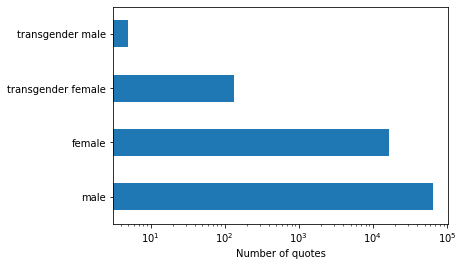

In [39]:
pd.merge(df_speakerinfo.gender.str[0].to_frame(), readable, right_on = "QID", left_on = "gender").Label.value_counts().plot.barh()
plt.xscale("log")
plt.xlabel("Number of quotes")
plt.show()

We want to get an idea about the frequency of quotations divided by the political party of its speaker. To get just a rough idea of this distribution we plot it considering just the first party in the party list of each politician, even if we are aware that this not always corresponds to the last party they were into.

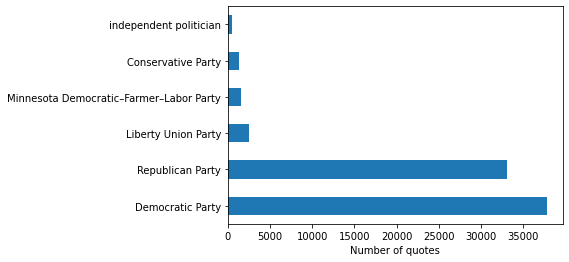

In [40]:
pd.merge(df_speakerinfo.party.str[0].to_frame(), readable, right_on = "QID", left_on = "party").Label.value_counts()[:6].plot.barh()
plt.xlabel("Number of quotes")
plt.show()

We can also choose some of the most popular politicans from both major parties and we take a look at how many quotes they have in the dataset since we will be interested also in the comparison beteen just two (or few) opposite politicians.

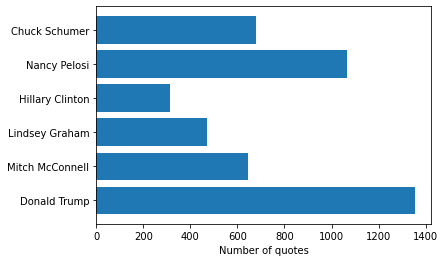

In [41]:
politicians = ["Donald Trump", "Mitch McConnell", "Lindsey Graham", "Hillary Clinton", "Nancy Pelosi", "Chuck Schumer"]
n_quotes = []
for politician in politicians:
  n_quotes.append(len(df.loc[df.speaker == politician]))
plt.barh(politicians, n_quotes)
plt.xlabel("Number of quotes")
plt.show()

Now we can start trying to use the NLTK library to tokenize the quotations and proceed with the analysis.

We firstly want to stem the all the words, in order to avoid double counting of words such as "graduation", "graduate" and "graduated". Then we also want to remove all the stopwords, for example "and", "a", "or".

In [42]:
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer, LancasterStemmer
import nltk
import string
from nltk.corpus import stopwords
from operator import itemgetter
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We create a `tokenize` function, which removes the punctuation, remove english stopwords and then apply the stemming.

In [43]:
def tokenize(text, stemmer):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens if word not in stopwords.words('english')])

We can choose between different stemming methods, so we try the three most commonly used (Porter, Snowball and Lancaster) on five random quotations on the dataset to see practically how they differ one from each other.

In [44]:
for i in range(5):
  print('quotation', i, ': ', df.iloc[i+100,1])

quotation 0 :  Regardless of what situation a mom presents herself in, (this program has the) connections across the community that you can actually show 15 years after the intervention. The little one is more likely to stay in high school, to get into the workforce and not be incarcerated.
quotation 1 :  Sanders is appealing to them and if that doesn't work for them, then the Trump team hopes they'll come their way.
quotation 2 :  She is in a bit of limbo at this point,
quotation 3 :  single-best tool to inform decisions.
quotation 4 :  So thank you to everybody who's doing what I'm doing, working from home to stop the spread of the virus from household to household. That's the way we're going to win. We're going to beat it and we're going to beat it together. Stay at home, protect the NHS, and save lives.


In [45]:
# Porter Stemmer
stemmer_p = PorterStemmer()

for i in range(5):
  print('quotation', i, ': ', tokenize(df.iloc[i+100,1], stemmer_p))

quotation 0 :  regardless situat mom present program connect across commun actual show 15 year intervent the littl one like stay high school get workforc incarcer
quotation 1 :  sander appeal doesnt work trump team hope theyll come way
quotation 2 :  she bit limbo point
quotation 3 :  singlebest tool inform decis
quotation 4 :  so thank everybodi who im work home stop spread viru household household that way go win were go beat go beat togeth stay home protect nh save live


In [46]:
# Snowball Stemmer
stemmer_s = SnowballStemmer('english')

for i in range(5):
  print('quotation', i, ': ', tokenize(df.iloc[i+100,1], stemmer_s))

quotation 0 :  regardless situat mom present program connect across communiti actual show 15 year intervent the littl one like stay high school get workforc incarcer
quotation 1 :  sander appeal doesnt work trump team hope theyll come way
quotation 2 :  she bit limbo point
quotation 3 :  singlebest tool inform decis
quotation 4 :  so thank everybodi whos im work home stop spread virus household household that way go win were go beat go beat togeth stay home protect nhs save live


In [47]:
# Lancaster
stemmer_l = LancasterStemmer()

for i in range(5):
  print('quotation', i, ': ', tokenize(df.iloc[100+i,1], stemmer_l))

quotation 0 :  regardless situ mom pres program connect across commun act show 15 year interv the littl on lik stay high school get workforc incarc
quotation 1 :  sand ap doesnt work trump team hop theyl com way
quotation 2 :  she bit limbo point
quotation 3 :  singlebest tool inform decid
quotation 4 :  so thank everybody who im work hom stop spread vir household household that way going win wer going beat going beat togeth stay hom protect nhs sav liv


We clearly see that Porter and Snowball are similar to each other while Lancaster is way more aggressive. Between Porter and Snowball we choose the latter one as, even if similar, we think that it is more appropriate for some types of words, as shown below:

In [48]:
# Porter
print(stemmer_p.stem("generously"))

gener


In [49]:
# Snowball
print(stemmer_s.stem("generously"))

generous


Now we can procced with the creation of the vocabulary containing all the words of the quotations

In [50]:
quotations_list = df.loc[:,'quotation'].values.tolist() # Merge all the quotations in a single list

In [51]:
words = [tokenize(d, stemmer_s).split() for d in quotations_list] # create a list of all the single words in each quotation

Finally from the `words` datset we can create the vocabulary, a list containg all the unique words contained in all the quotations.

In [52]:
vocabulary = list(set([item for sublist in words for item in sublist]))
vocabulary.sort()

If, for example, we want to assess the frequency of words in a single quotation (or in a subset of them) we can simply use the function `Counter`:

In [53]:
df.iloc[10,1]

'arts workers are right up there. They are already feeling it and feeling an extreme loss of income and do see what is going to help them in the future.'

In [54]:
Counter(words[10])

Counter({'alreadi': 1,
         'art': 1,
         'extrem': 1,
         'feel': 2,
         'futur': 1,
         'go': 1,
         'help': 1,
         'incom': 1,
         'loss': 1,
         'right': 1,
         'see': 1,
         'they': 1,
         'worker': 1})

Using an external dataset about the most frequent words in english, coming from many different sources (Academic, Web, BLOGS, TV, spoken language etc.) we were able to build a function which checks if each word is more used in spoken language or academic setting.

In [55]:
# import the additional dataset
df_words = pd.read_excel ('/content/drive/MyDrive/wordFrequency.xlsx', sheet_name="1 lemmas")
df_words_cut = df_words[["lemma", "spokPM", "acadPM"]]
df_words_cut = df_words_cut.drop_duplicates(subset=['lemma'])

In [56]:
def level_score(quote, verbose=True):
  """
  Draft version of the function that will provide us a score indicative of the level of 
  language used. In this version, it compares the words of the quote with the dataset from COCA
  and checks if each word is more used in spoken language or in academic setting.

  Example of use:
  level_score("Hypothesis testing is an act in statistics whereby an analyst tests an assumption regarding a population parameter")

  output:
  tuple (number of words more used in spoken language, number of words more used in academic language)
  """
  quote = quote.split()
  data_words = df_words_cut[df_words_cut.isin(quote).lemma==True].copy()
  data_words["spoken"] = data_words["spokPM"] > data_words["acadPM"]
  spoken_w = np.sum(data_words["spoken"])
  acad_w = len(data_words) - spoken_w
  if verbose:
    for i in quote:
      output = "Spoken language" if data_words[data_words["lemma"]==i]["spoken"].all() else "Academic language"
      print(f"{i}: {output}")
    print("\n")
    print(f"Count of spoken language words: {spoken_w}")
    print(f"Count of academic language words: {acad_w}")
  return spoken_w, acad_w

_, _ = level_score("Hypothesis testing is an act in statistics whereby an analyst tests an assumption regarding a population parameter")

Hypothesis: Spoken language
testing: Academic language
is: Spoken language
an: Spoken language
act: Academic language
in: Academic language
statistics: Academic language
whereby: Spoken language
an: Spoken language
analyst: Spoken language
tests: Spoken language
an: Spoken language
assumption: Academic language
regarding: Academic language
a: Spoken language
population: Academic language
parameter: Academic language


Count of spoken language words: 2
Count of academic language words: 8


Building upon this function we will be able to build different metrics to evaluate the level of english of a certain quote considering in which setting each word is more likely to be used.

With this data cleaning we performed, with the metrics we created, the creation of the vocabulary of words and their occurrences, and with the integration of the additional dataset, we will be able to perform the intended analysis about the differences in communication styles between politicians from different political parties.